Dataset used: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data

In [1]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_density, xlim, labs
import pandas as pd
import seaborn as sns
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

In [30]:
# Load a CSV file
df15 = dd.read_csv('./yellow_tripdata_2015-01.csv', assume_missing=True)
df16 = dd.read_csv('./yellow_tripdata_2016-01.csv', assume_missing=True)

df = dd.concat([df15, df16])

# Exploratory data analysis

In [3]:
df_len = len(df)
df_len

23655844

The dataframe has 23.655.844 entries.

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RatecodeID
0,2.0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.0,1.59,-73.993896,40.750111,1.0,N,-73.974785,40.750618,1.0,12.0,1.0,0.5,3.25,0.0,0.3,17.05,NaN
1,1.0,2015-01-10 20:33:38,2015-01-10 20:53:28,1.0,3.30,-74.001648,40.724243,1.0,N,-73.994415,40.759109,1.0,14.5,0.5,0.5,2.00,0.0,0.3,17.80,NaN
2,1.0,2015-01-10 20:33:38,2015-01-10 20:43:41,1.0,1.80,-73.963341,40.802788,1.0,N,-73.951820,40.824413,2.0,9.5,0.5,0.5,0.00,0.0,0.3,10.80,NaN
3,1.0,2015-01-10 20:33:39,2015-01-10 20:35:31,1.0,0.50,-74.009087,40.713818,1.0,N,-74.004326,40.719986,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,NaN
4,1.0,2015-01-10 20:33:39,2015-01-10 20:52:58,1.0,3.00,-73.971176,40.762428,1.0,N,-74.004181,40.742653,2.0,15.0,0.5,0.5,0.00,0.0,0.3,16.30,NaN


I see two columns with the name RateCodeID and RatecodeID which have NaN values. I plan to check if they contain the same information. Also some column data types not of the collect types we would expect. For example we can see categories with low values being floats and in the next section we can see that the datetime is in string[pyarrow] format instead of datetime format. Also the store_and_fwd_flag is similar. This is why I reload the data specifying the correct types although this did not work for RateCodeID for some reason even though I speceify it but I fix that later.

In [37]:
# A look at the column types
print("Old types: \n{}".format(df.dtypes))
types = {'VendorID': 'int8', 'passenger_count': 'int8',
          'RateCodeID': 'int8', 'payment_type': 'int8',
          'RatecodeID': 'int8'}
# Reread with better data types
df15 = dd.read_csv('./yellow_tripdata_2015-01.csv', assume_missing=True, dtype=types)
df16 = dd.read_csv('./yellow_tripdata_2016-01.csv', assume_missing=True, dtype=types)


df = dd.concat([df15, df16])

Old types: 
VendorID                            int8
tpep_pickup_datetime     string[pyarrow]
tpep_dropoff_datetime    string[pyarrow]
passenger_count                     int8
trip_distance                    float64
pickup_longitude                 float64
pickup_latitude                  float64
RateCodeID                       float64
store_and_fwd_flag       string[pyarrow]
dropoff_longitude                float64
dropoff_latitude                 float64
payment_type                        int8
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
RatecodeID                       float64
dtype: object


I will also convert the datetime from a string to datetime format type.

In [38]:
df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

If we look at the amount of NaN values in the RateCodeID and the ones in RatecodeID and sum them we can see that we get the amount of samples. Maybe it is because the data is divided into two csv's and the columns changed. Doing this we can also see 3 samples have a NaN improvement_surcharge so we can remove those as well

In [8]:
print(df.isnull().sum().compute())

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count                 0
trip_distance                   0
pickup_longitude                0
pickup_latitude                 0
RateCodeID               10906858
store_and_fwd_flag              0
dropoff_longitude               0
dropoff_latitude                0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           3
total_amount                    0
RatecodeID               12748986
dtype: int64


Let us check if we have columns where both RatecodeID and RateCodeID are NaN at the same time

In [39]:
ratecodeIDNull = df['RatecodeID'].isnull()
rateCodeIDNull = df['RateCodeID'].isnull()

df_with_nan = df[rateCodeIDNull & ratecodeIDNull]
print("{} samples are null at the same time".format(len(df_with_nan)))

0 samples are null at the same time


We can see that when RateCodeID is NaN RatecodeID is not and vice verca. Theis is cause the column was renamed in the 2016 version.
I will check if there are other different columns and see that it is only the RateCodeID.

In [11]:
print("Different columns", np.sum(df15.columns != df16.columns))

Different columns 1


I rename and reconcatenate to fix the issue

In [ ]:
df16 = df16.rename(columns={'RatecodeID': 'RateCodeID'})
df = dd.concat([df15, df16])
df['RateCodeID'] = df['RateCodeID'].astype('int8')

Now all we are left with is the surcharge with NaN values. Since these are only 3 elements and we have 23 million I would say it is safe to remove them from the dataset. 

In [14]:
# Drop the rows with NaN values
df = df.dropna(subset=['improvement_surcharge'])

Now we will see we have no NaN or null values. This doesn't mean latitude and longtitude can't be zero though.

In [40]:
df = df.persist()  # Compute and keep the result in memory

print(df.isnull().sum().compute())

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count                 0
trip_distance                   0
pickup_longitude                0
pickup_latitude                 0
RateCodeID               10906858
store_and_fwd_flag              0
dropoff_longitude               0
dropoff_latitude                0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           3
total_amount                    0
RatecodeID               12748986
dtype: int64


While playing around with the data I noticed latitude and longtitude for both pickup and dropoff are zero sometimes. This makes me believe they are also missing values but not detected by isnull() so I can not count on them always. Another thing I noticed are the types of stuff like passenger_count and VendorID which seem to be float but an int should be sufficient since they take up more space being floats. 

In [16]:
print("pickup zero values: latitude", (df["pickup_latitude"] == 0).sum().compute(), "longitude", (df["pickup_longitude"] == 0).sum().compute())
print("dropoff zero values: latitude", (df["dropoff_latitude"] == 0).sum().compute(), "longitude", (df["dropoff_longitude"] == 0).sum().compute())
print("both zero values: latitude", ((df["dropoff_latitude"] == 0) & (df['pickup_latitude'] == 0)).sum().compute(),
         "longitude", ((df["dropoff_longitude"] == 0) & (df['pickup_longitude'] == 0)).sum().compute())

pickup zero values: latitude 413687 longitude 413687
dropoff zero values: latitude 395567 longitude 395566
both zero values: latitude 358613 longitude 358613



In the above we see how many longtitude and latitude values are missing and that not always are they missing at the same time. Since we have a big dataset deleting less than half a million examples I don't thinks would be an issue. I would like to see if they are evenly distributed though since it is possible we will lose data for a specific period where we had issues calculating it

In [17]:
missing_lat_lon_idx = (df["pickup_latitude"] == 0) | (df["pickup_longitude"] == 0) | (df["dropoff_latitude"] == 0) | (df["dropoff_longitude"] == 0)
missing_lat_lon = df[missing_lat_lon_idx]

missing_lat_lon['tpep_pickup_datetime'] = dd.to_datetime(missing_lat_lon['tpep_pickup_datetime'])
missing_lat_lon['tpep_dropoff_datetime'] = dd.to_datetime(missing_lat_lon['tpep_dropoff_datetime'])

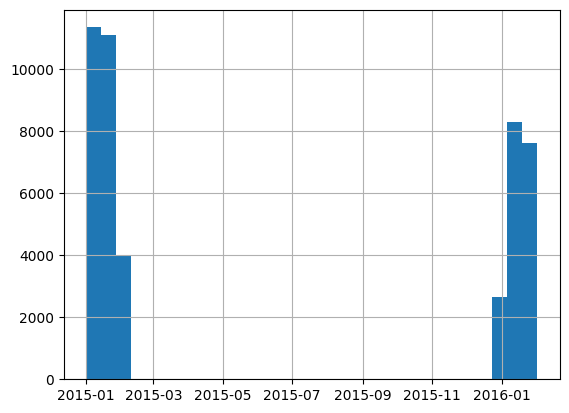

In [19]:
# Sample 5000 rows from the DataFrame
df_sample = missing_lat_lon.sample(frac=0.1, random_state=1)

df_sample['tpep_pickup_datetime'].compute().hist(bins=30)

# Show the plot
plt.show()

As we can see in the graph above it seems the data is distributed somewaht evenly in January of 2015 and 2016. So it was not a specific period. We can drop the data but if this happens from time to time. These samples can be used for the trip_distance estimation task if we want to estimate the distance we might like to keep these samples to prevent from just using latitude and longitude and manhattan distance to get good results for trip distance. A seperate model just for that case might be generally usefull.

In [20]:
print("Max value of RateCodeID:", np.max(df['RateCodeID'].compute()))
print("RateCodeID greater than 6/equal to 99 amount:", np.sum(df['RateCodeID'].compute() == 99))

Max value of RateCodeID: 99
RateCodeID greater than 6/equal to 99 amount: 723


While looking at plots I found that RateCodeID can be 99. This seems to be a replacement for Null

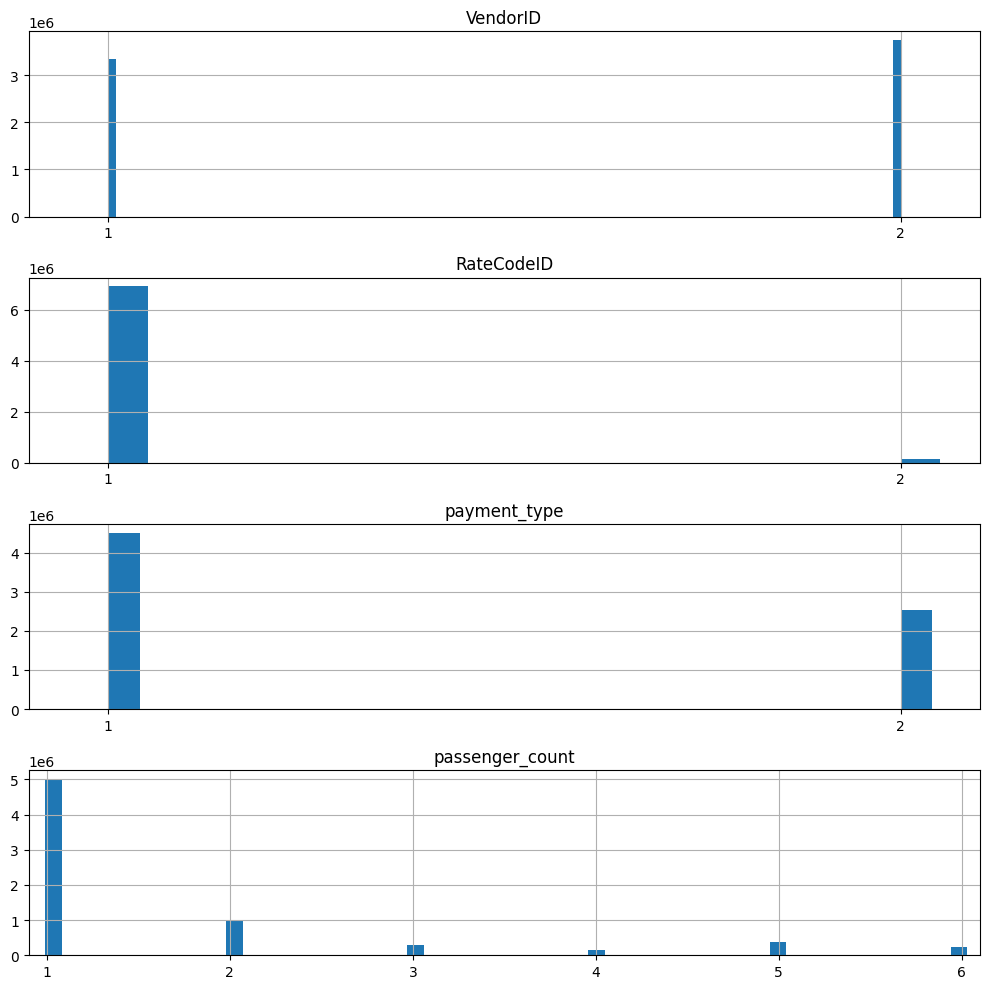

In [21]:
df_sample = df.sample(frac=0.3)  

df_sample_pd = df_sample.compute()

# Remove samples where the RateCodeID is 99 so we get a better histogram
# We already see the how many 99 values are in the set with my count above
df_sample_pd = df_sample_pd[df_sample_pd['RateCodeID'] <= 6]

columns_to_plot = ['VendorID', 'RateCodeID', 'payment_type', "passenger_count"]

fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(10, 10))

for ax, column in zip(axs, columns_to_plot):
    upper_limit = df_sample_pd[column].quantile(0.99)
    lower_limit = df_sample_pd[column].quantile(0.01)


    df_sample_pd[column].hist(bins=100, ax=ax)
    ax.set_xlim(lower_limit - 0.1, upper_limit + 0.1)
    ax.set_title(column)
    ax.xaxis.set_ticks(np.arange(lower_limit, upper_limit + 1, 1))

plt.tight_layout()
plt.show()

From the above plots we see we have more trips from Verifone(2) than from Creative Mobile Technologies(1). Most of the time one or 2 passengers are taken and the payment is cash(2) or card(1). And the most common rate is the standard one(1) followed by the JFK(2) one. Thanks to the Rate plot I managed to figure out that the RateCode can be 99 which was also useful. I removed it now so it gives us more valuable information.

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 13 rows containing non-finite values.


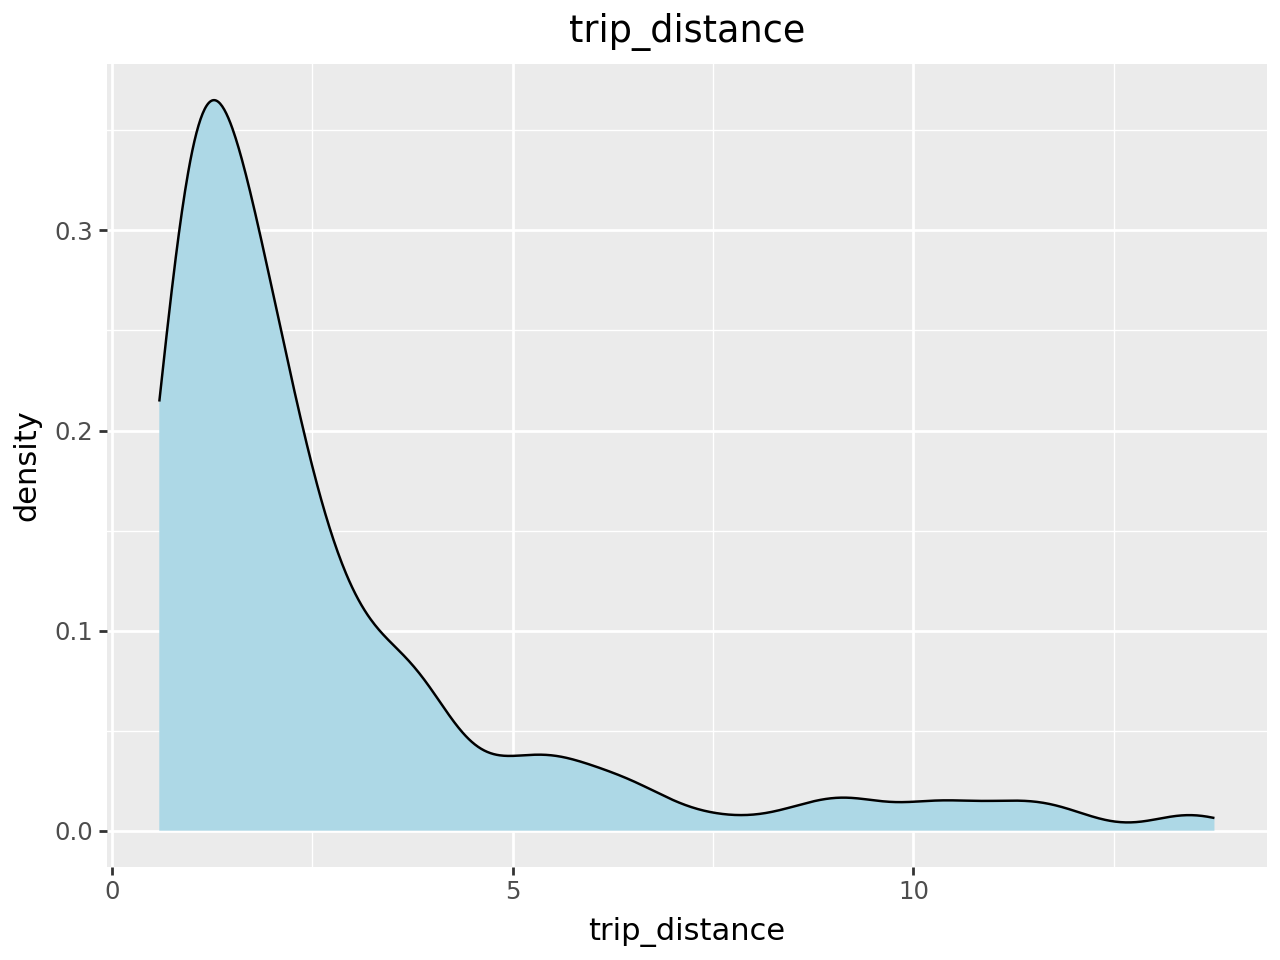

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 14 rows containing non-finite values.


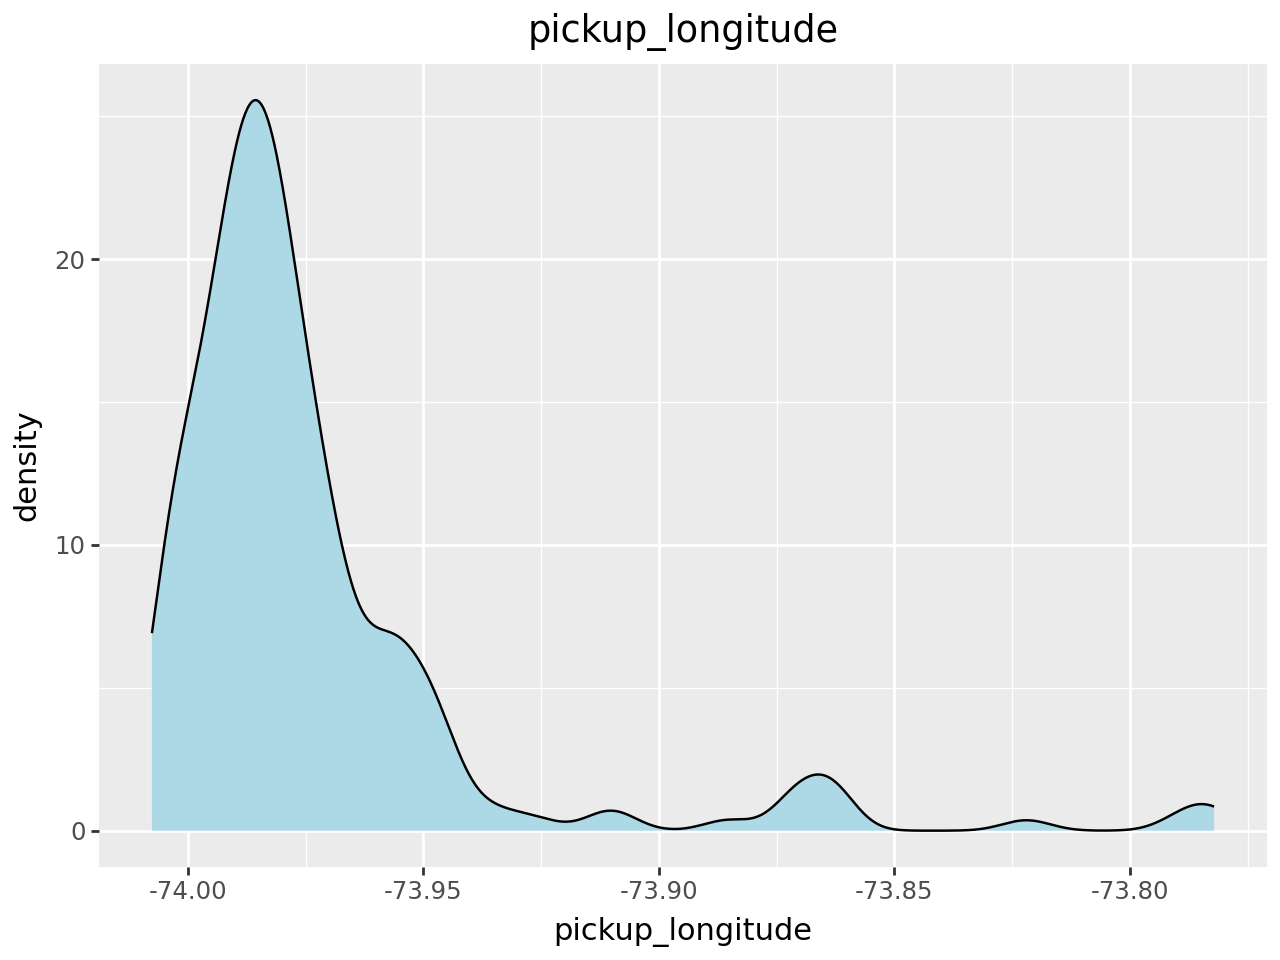

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 14 rows containing non-finite values.


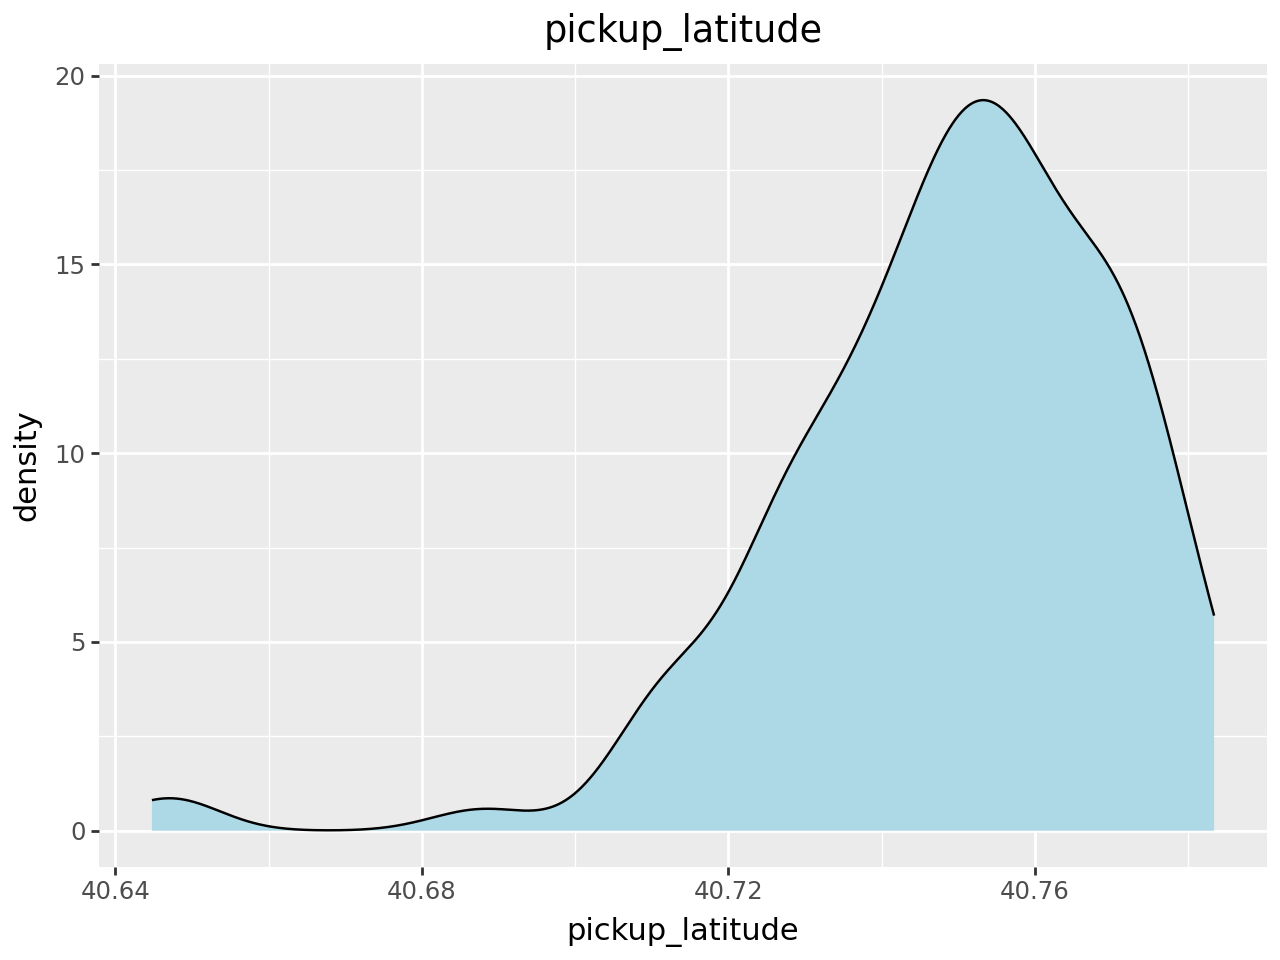

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 14 rows containing non-finite values.


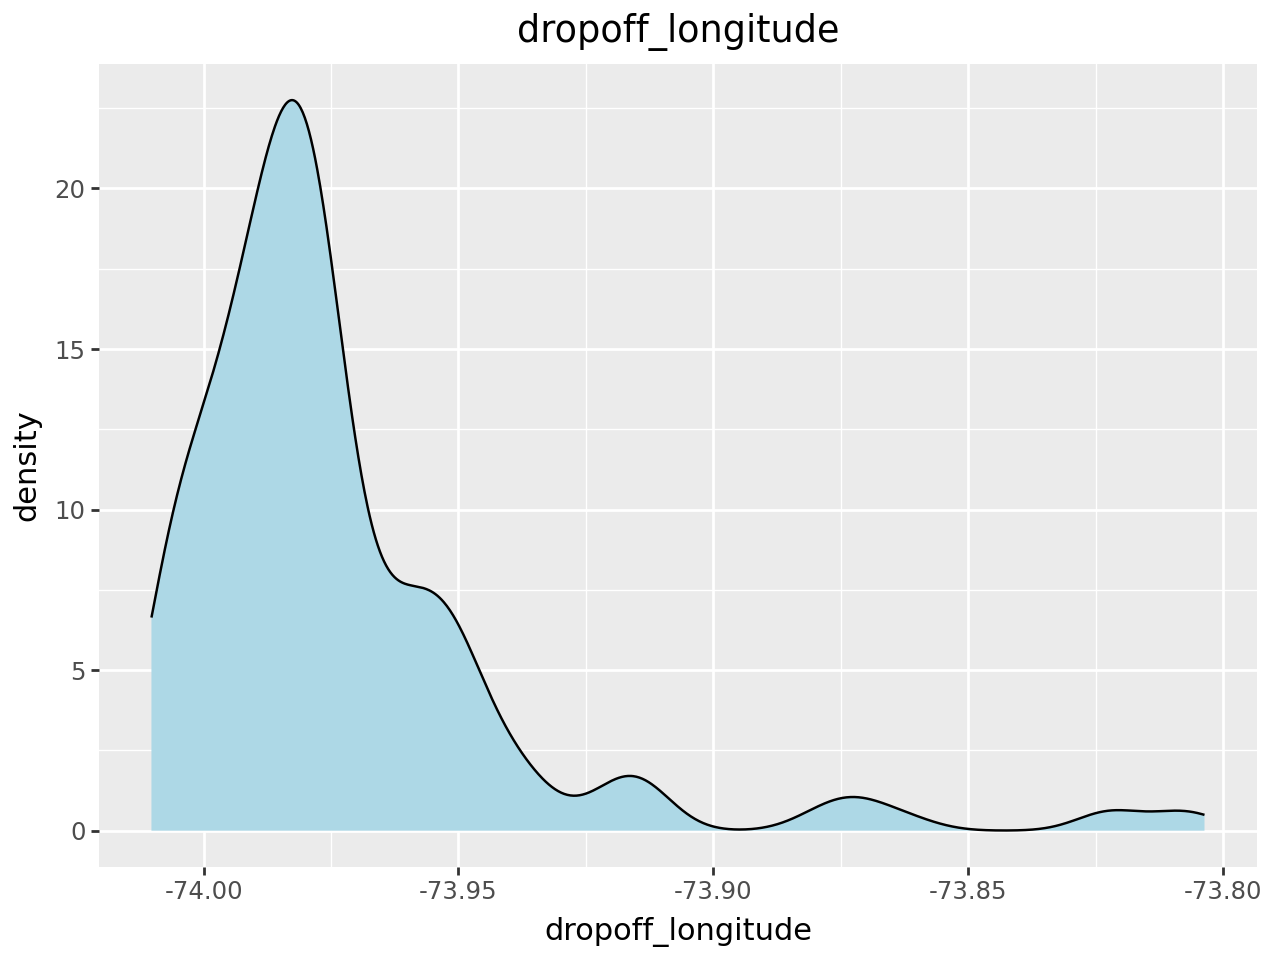

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 14 rows containing non-finite values.


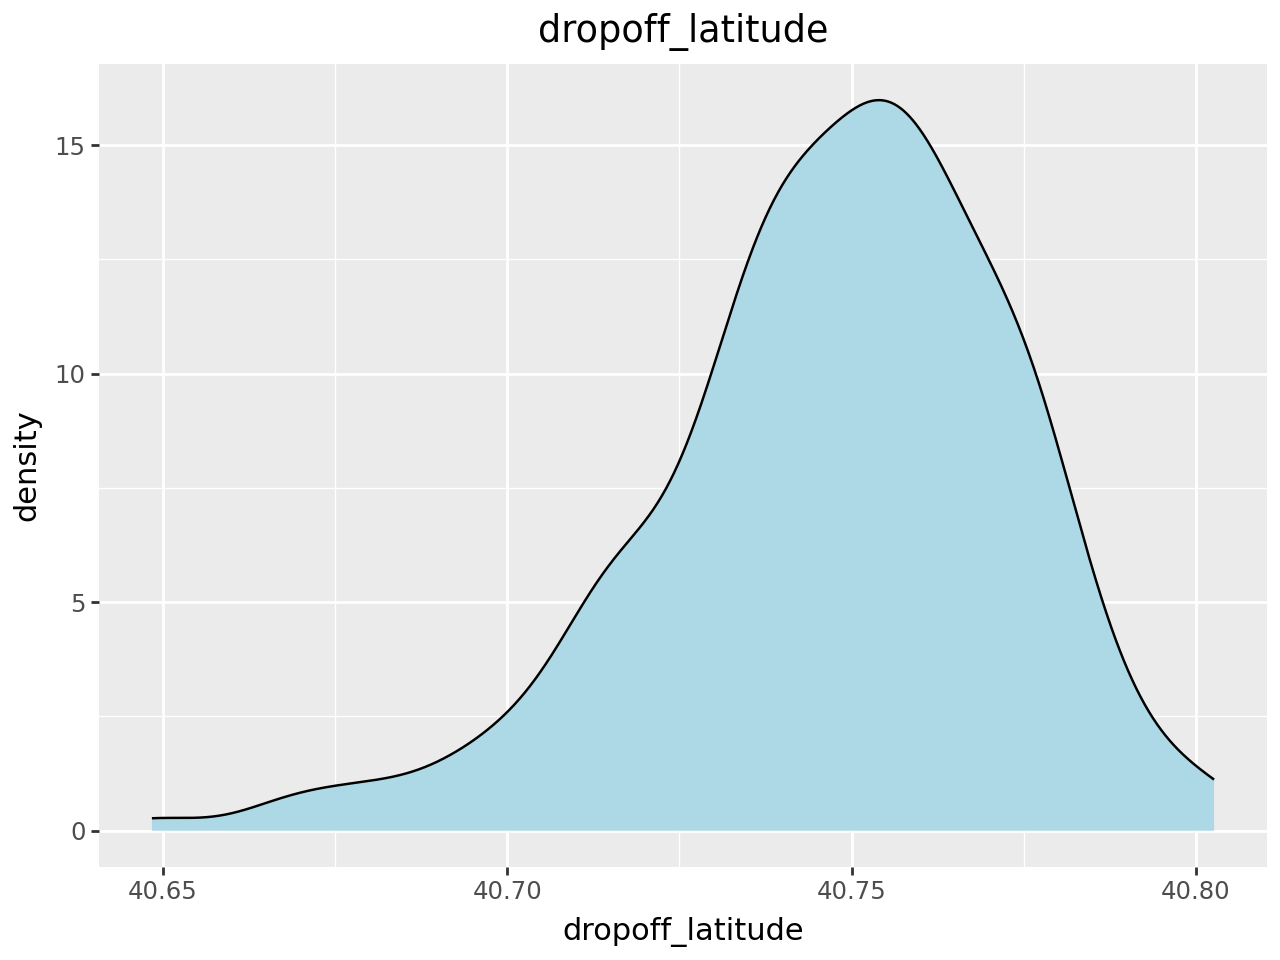

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 7 rows containing non-finite values.


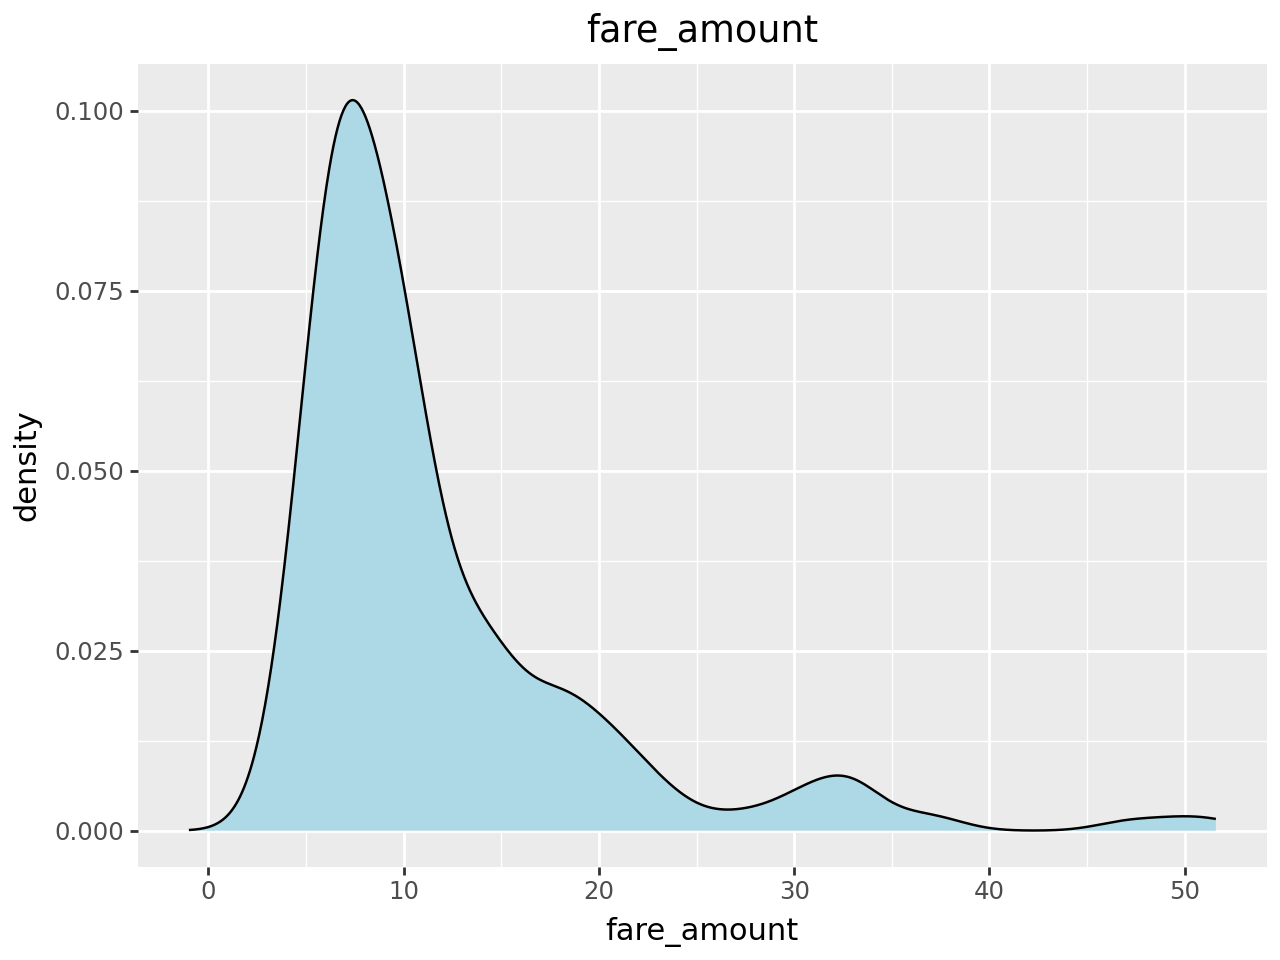

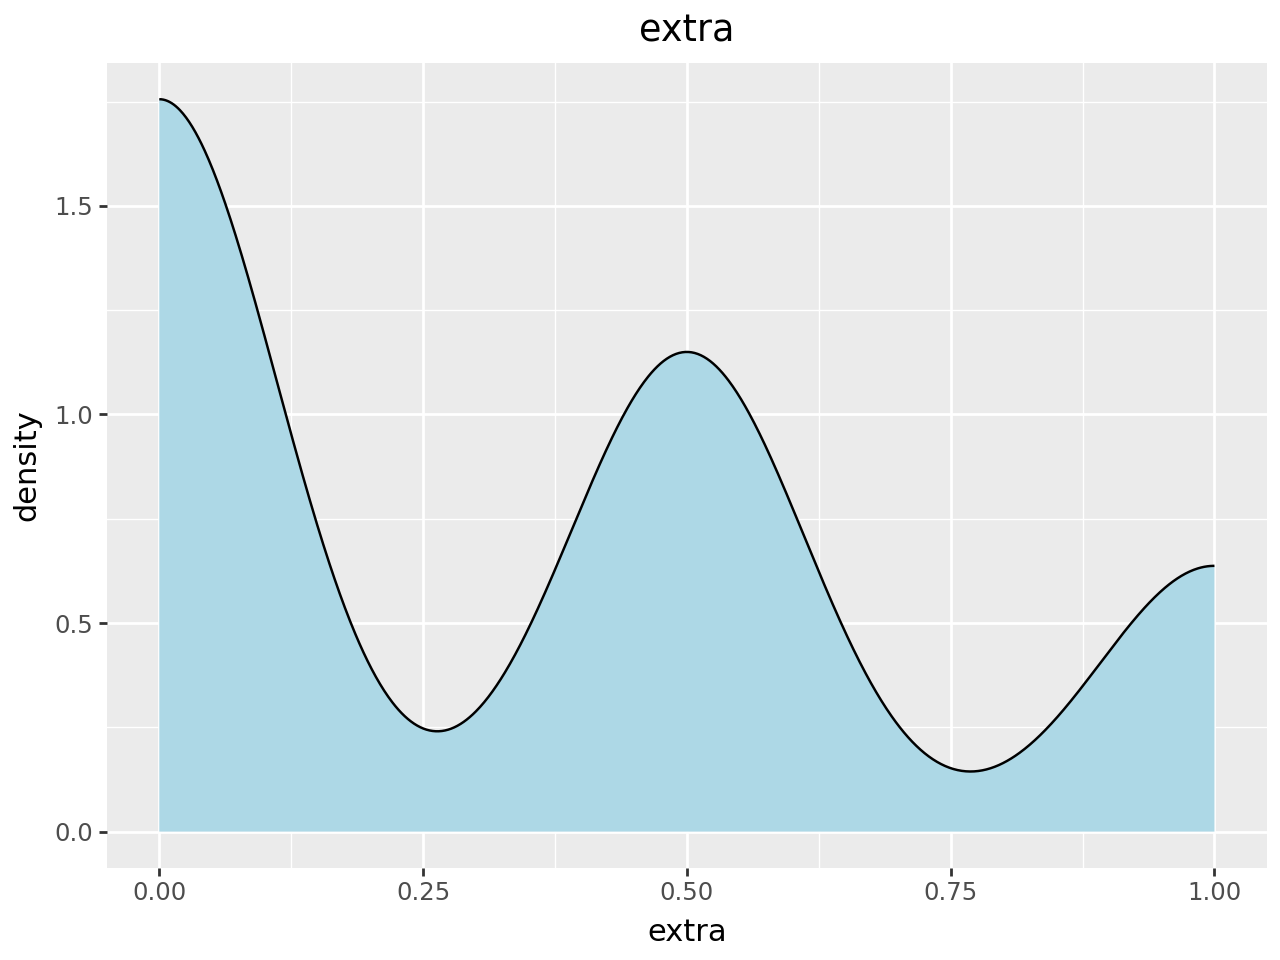

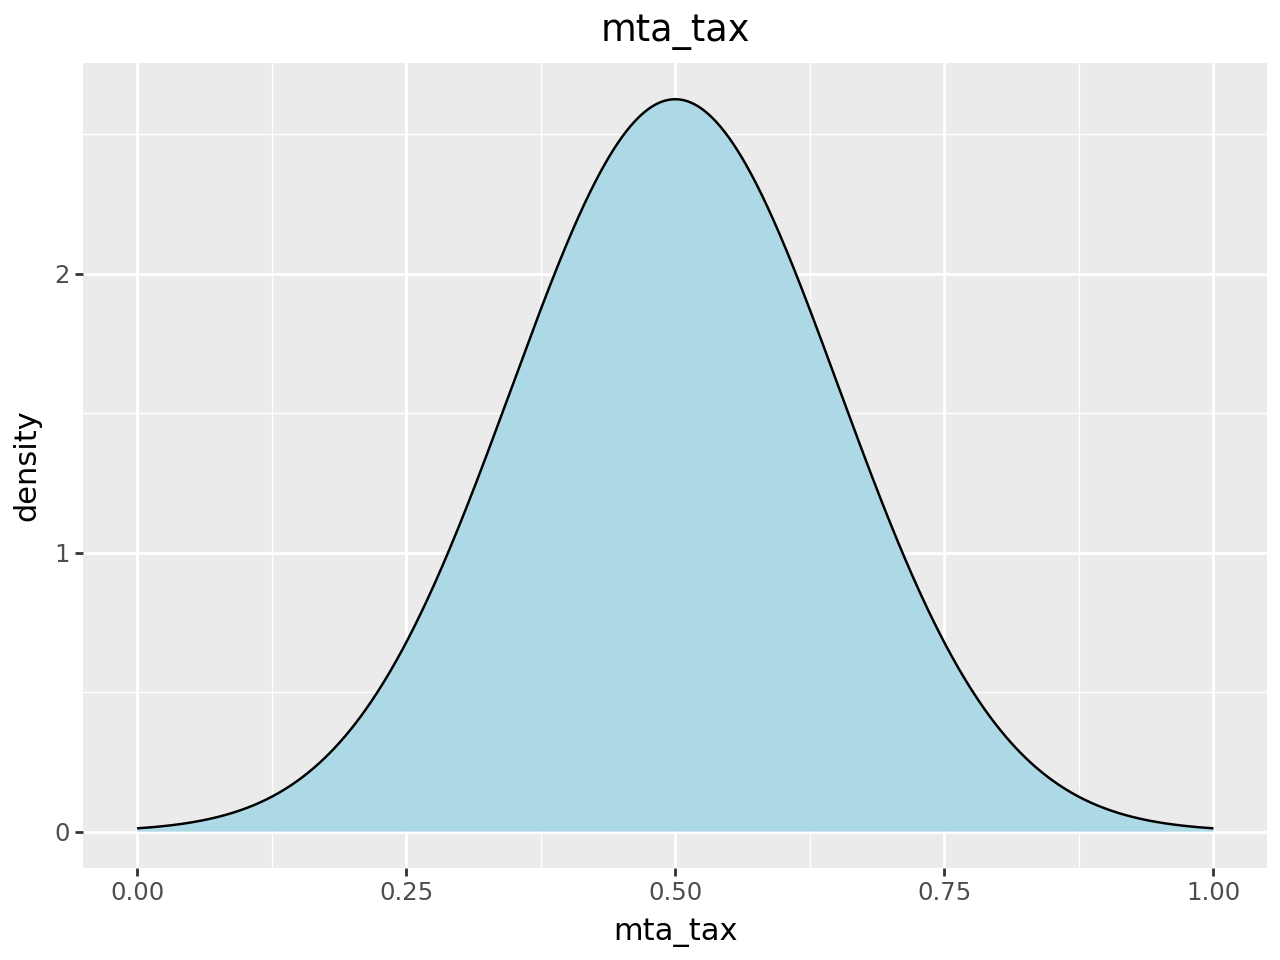

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 7 rows containing non-finite values.


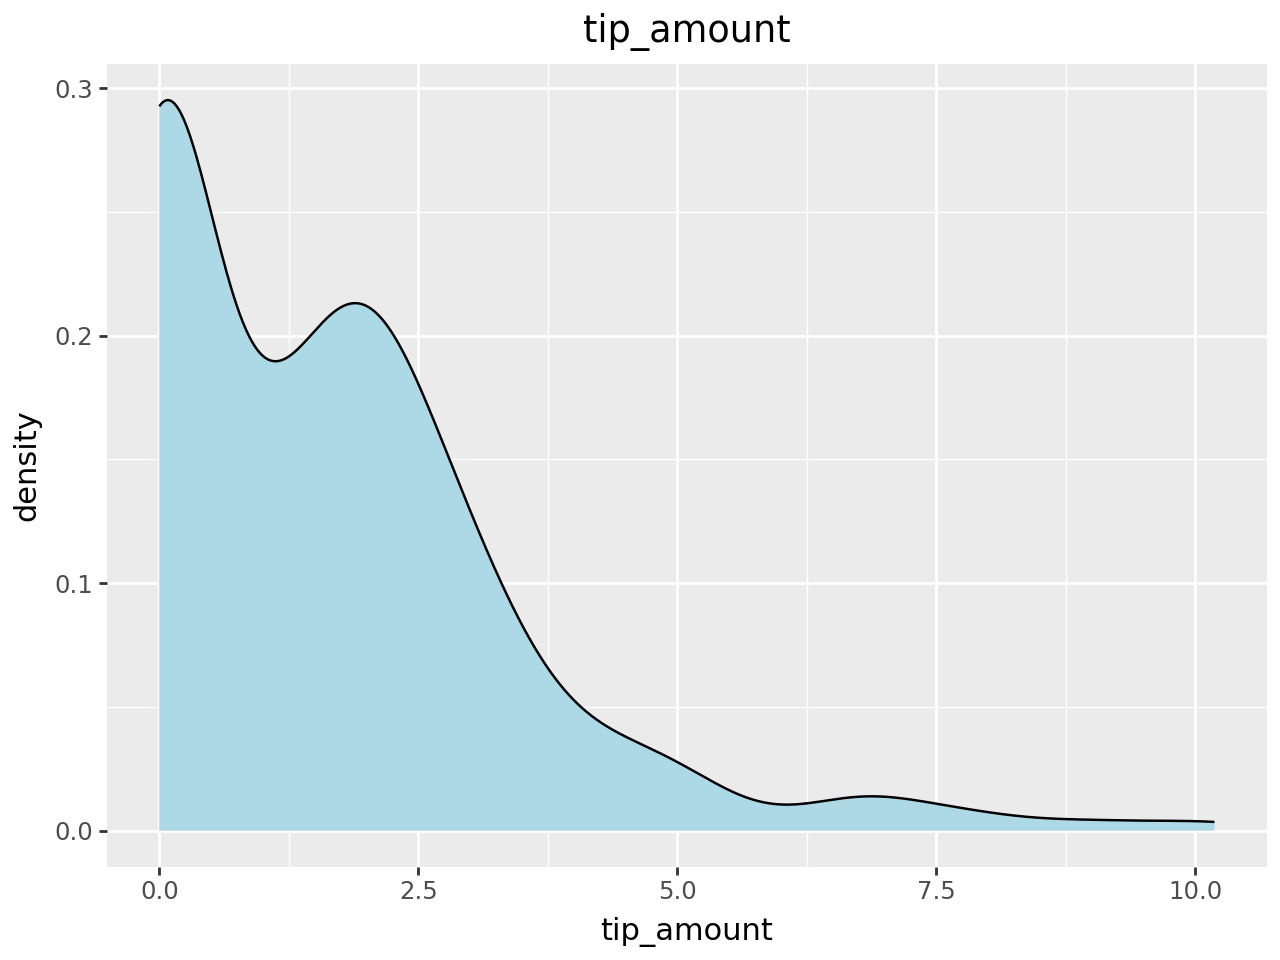

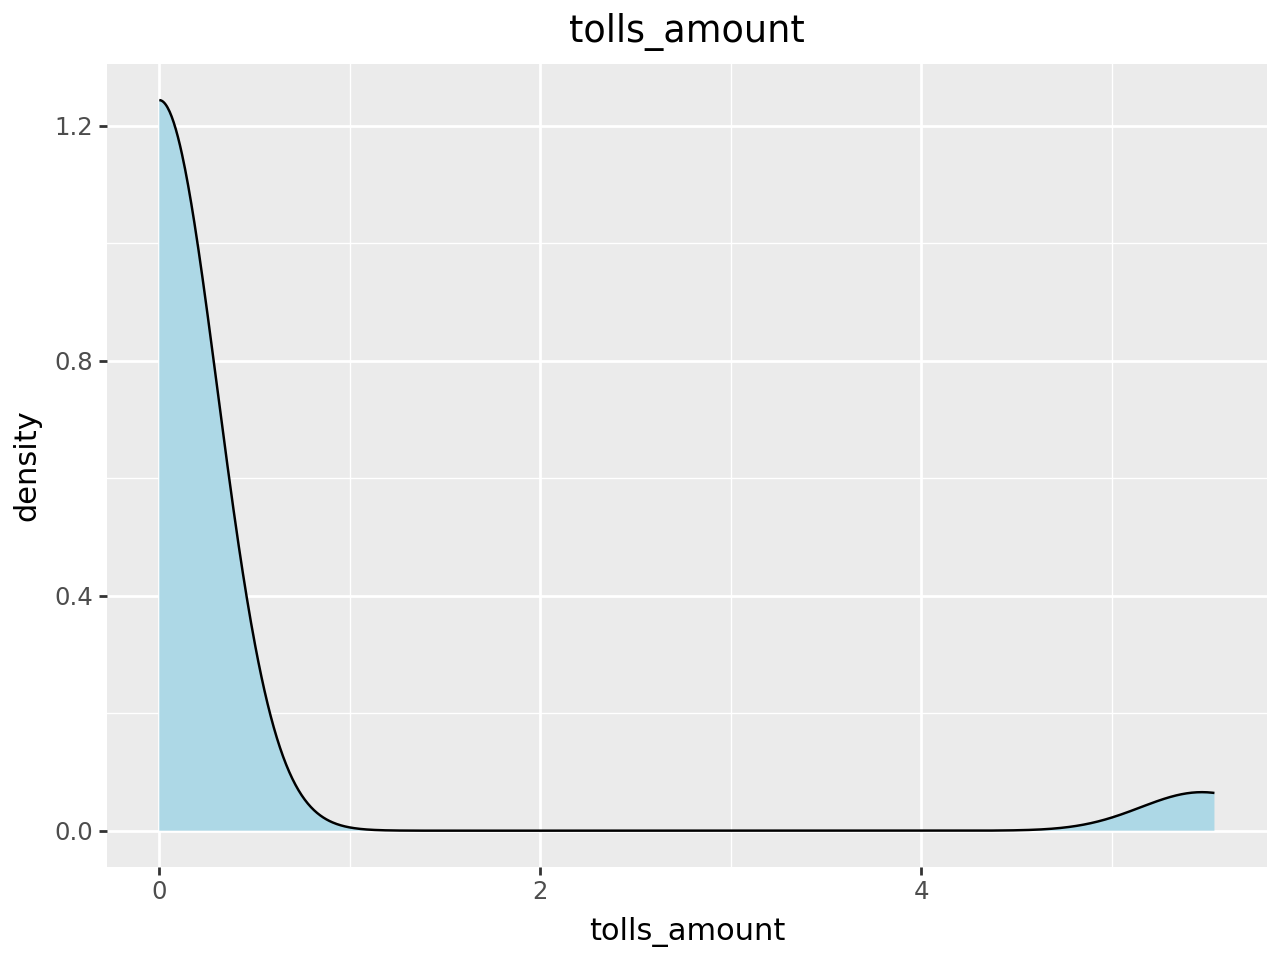

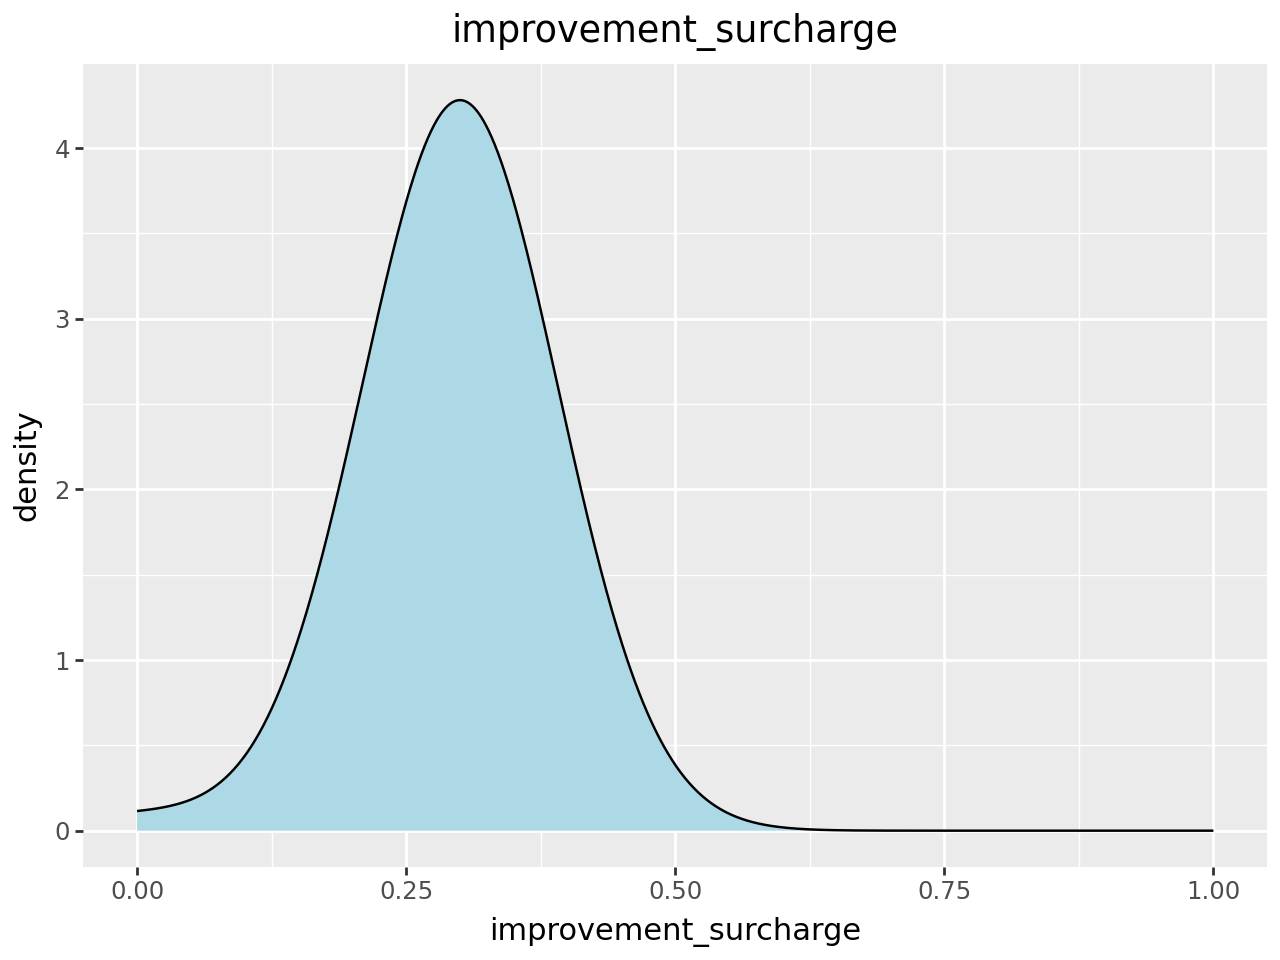

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 7 rows containing non-finite values.


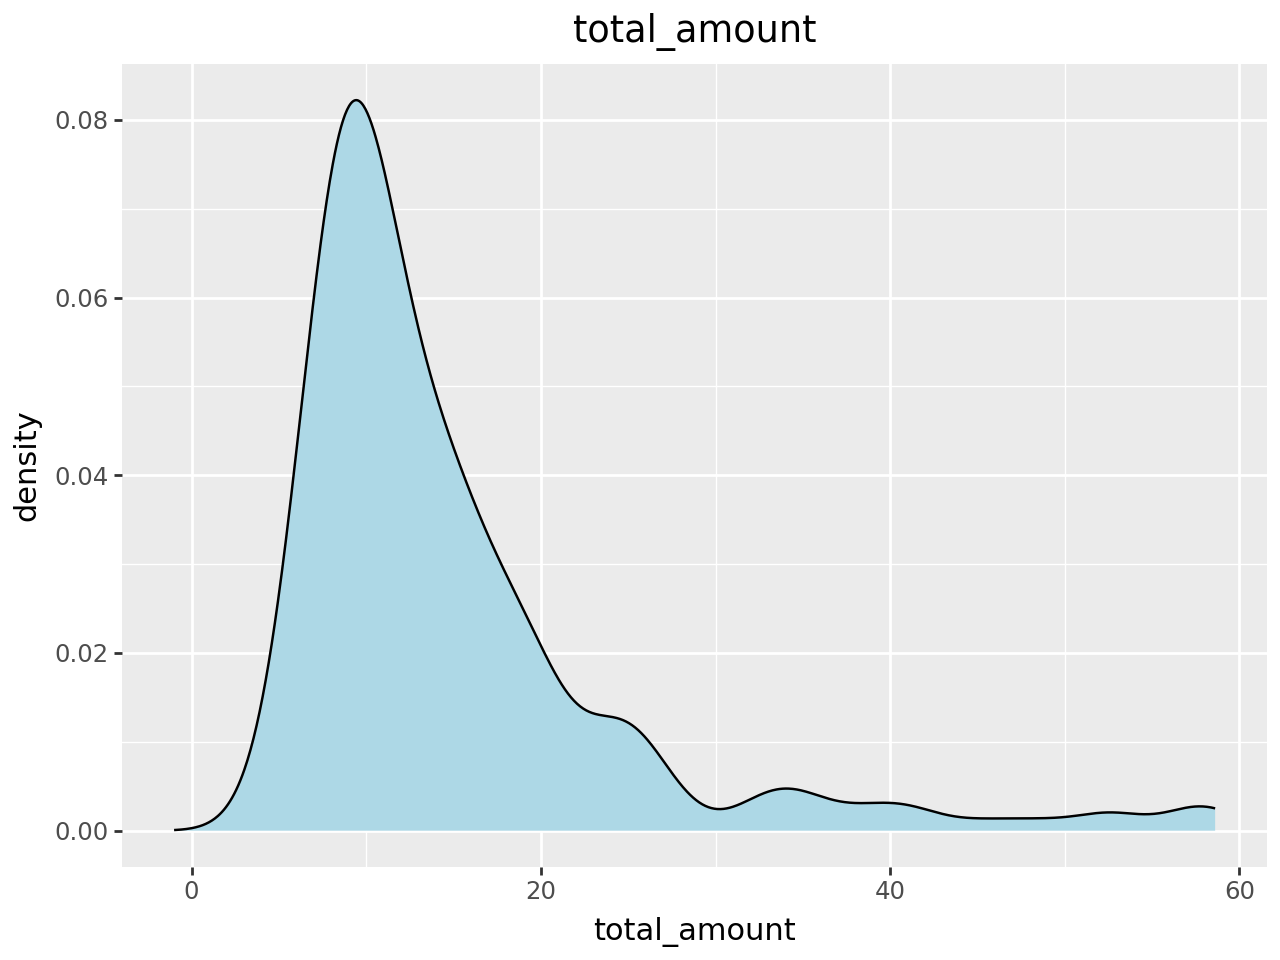

/home/nikolay/EMAI/Ljublajna/BigData/Assignment3/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 128 rows containing non-finite values.


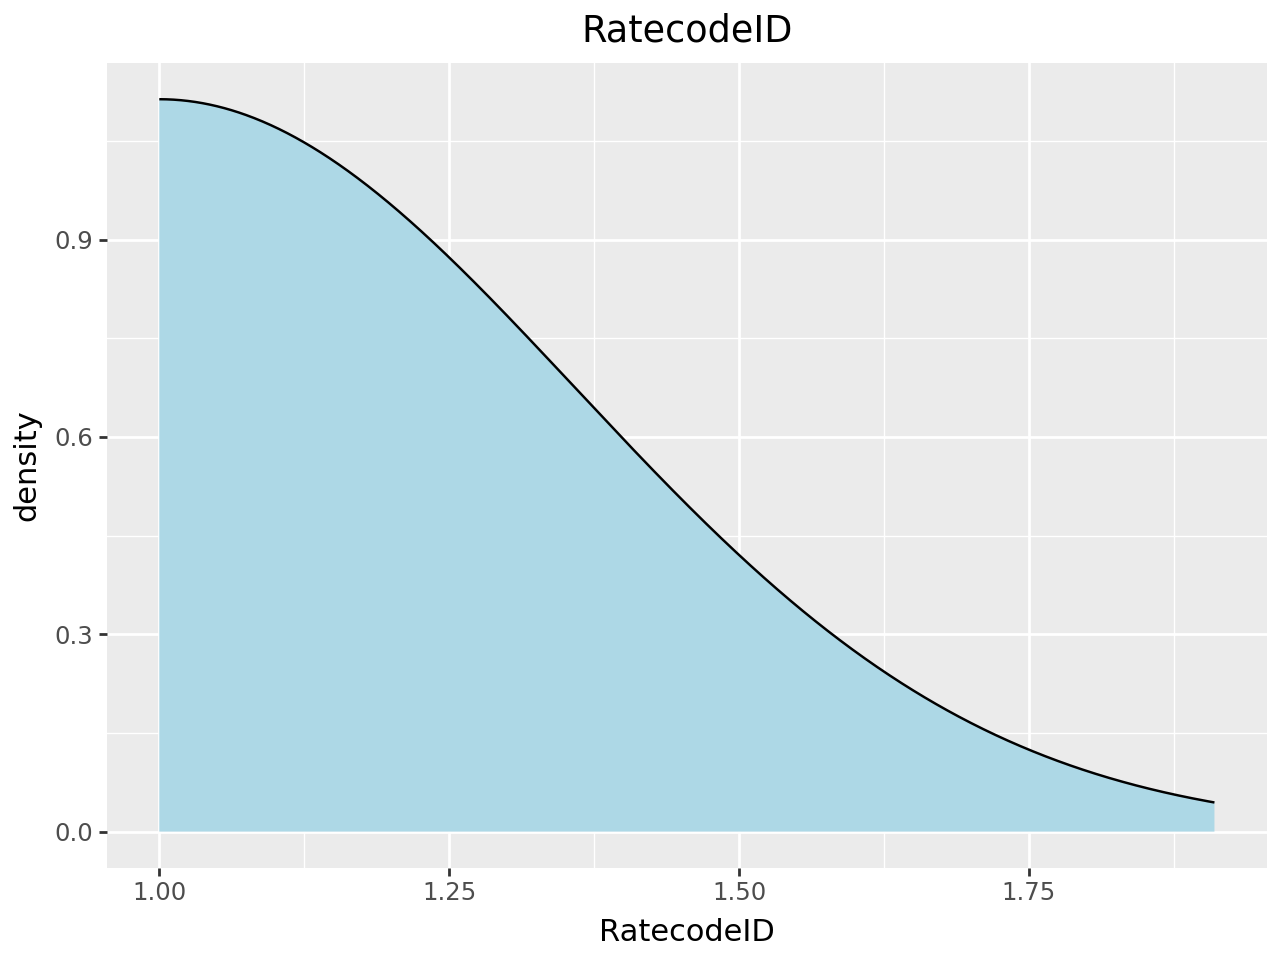

In [41]:
df_sample = df.sample(frac=0.00001)

df_sample_pd = df_sample.compute()

for column in df_sample_pd.select_dtypes(include=[np.number]).columns:
    if column in ['VendorID', 'RateCodeID', 'payment_type', "passenger_count"]:
        continue

    # Calculate the 1st and 99th percentiles
    # to make plots more interpretable
    lower_limit = df_sample_pd[column].quantile(0.03)
    upper_limit = df_sample_pd[column].quantile(0.97)
    if column == 'mta_tax' or column == 'improvement_surcharge':
        lower_limit = 0
        upper_limit = 1
    
    if column == 'fare_amount' or column == "total_amount":
        lower_limit = -1

    plot = (ggplot(df_sample_pd, aes(x=column)) +
            geom_density(fill='lightblue') +
            xlim(lower_limit, upper_limit) + 
            labs(title=column))  

    print(plot)

Based on the plots we can see how the values of the columns vary. For example the results show the tip amount somewhat exponentially dicreasing. Same as to see that most often the total amount for a taxi is less than 20 dollars. In these plots I did not find many outliers even when not using the quantiles for readability because the latitude and logntitued sometimes have 0 values and that makes the plot look unreadable. The other plots without the bounds look the same. Also we can see that the fare, tip, tolls and total amount can sometimes be negative. Maybe they returned a money to the passenger for a trip. These cases should be filtered out.

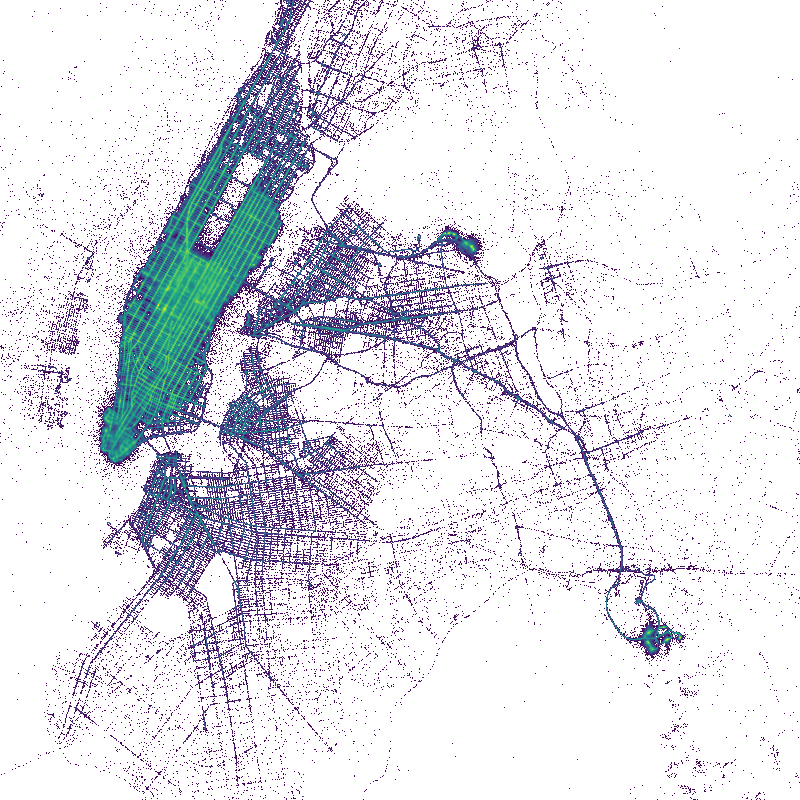

In [23]:
import datashader as ds
import datashader.transfer_functions as tf

df_sample_pd = df.compute()

offset = 0.05
x_range = (df_sample_pd.pickup_longitude.quantile(0.02) - offset, df_sample_pd.pickup_longitude.quantile(0.98) + offset)
y_range = (df_sample_pd.pickup_latitude.quantile(0.02) - offset, df_sample_pd.pickup_latitude.quantile(0.98) + offset)

canvas = ds.Canvas(plot_width=800, plot_height=800, x_range=x_range, y_range=y_range)

agg = canvas.points(df_sample_pd, 'pickup_longitude', 'pickup_latitude')

img = tf.shade(agg, cmap=plt.cm.viridis, how='log')

img

In the above plot we can see in which part of the city people are most often picked up from. I thought it would look cool so I decided to try it. Same can be done for dropoff locations. The lit up parts are the center and the airport which makes sense

In [7]:
def heatmap(df):
    corr_matrix = df.corr()

    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size as needed

    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, ax=ax)

    plt.xticks(rotation=65)

    plt.show()

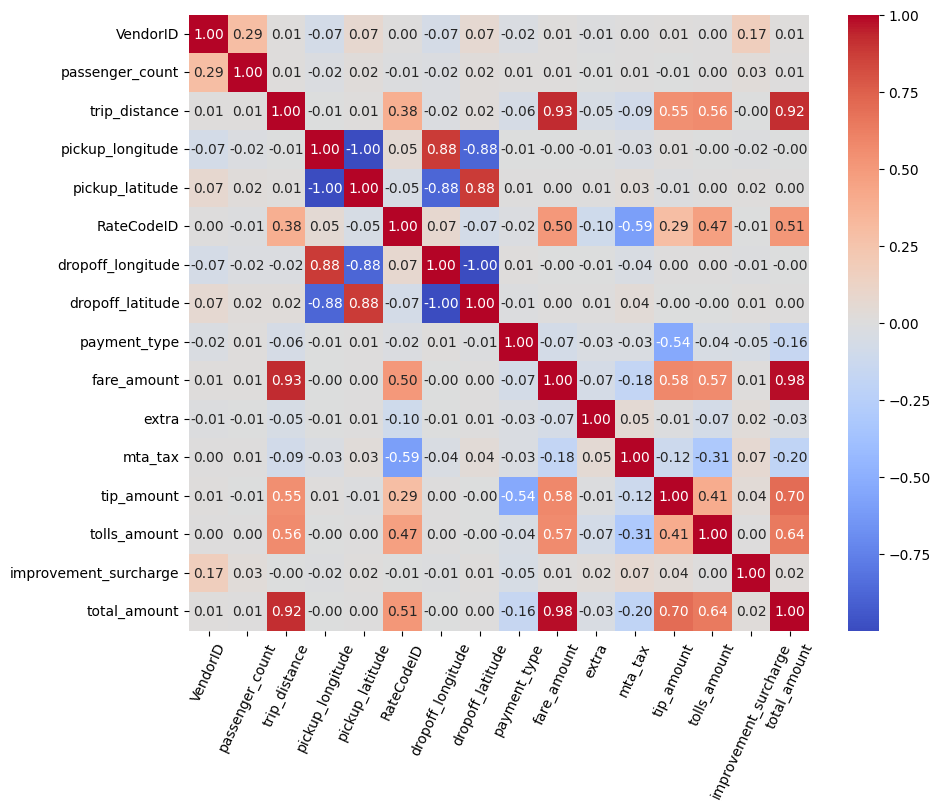

In [28]:
df_sample = df.sample(frac=0.001)  # Adjust the fraction as needed
df_numeric = df_sample.select_dtypes(include=[np.number])
heatmap(df_numeric.compute())

In the above heatmap we ca see the correlation between the numeric features. The ones that are highly correlated are the coordinates which is expected. Also the total amount and fare amount of course depend on the trip distance and vice verca. The coordinates seem unrelated to fare distance but I believe that if turned into manhattan distance they can be usefull. Also the tip amount and toll amount are related to the trip distance so they can be used in our estimations for the other tasks

### Think about the following issues: Which columns will you use? How are you going to use dates and times? Would you encode some columns?

So for the first questions I decided to use mainly the columns highly correlated to trip_distance for the second task of predicting it. Also the manhattan distance I plan to estimate.

For the second question I am sure that based on the time we can estimate if it is rush hour so that we can better see how long the fare took. The time itself will be quite usefull in estimating trip distance. I will convert it from the original format of departure and arrival time to three columns which will be elapsed time, hour of day and day of week. This way I have numeric features that can be input into a model.

For the encoding I changed the encoding of some columns and said my plans to combine others in sums or differences that can be seen as encodings.

### Handle missing data.
I just remove all rows with missing data in the next section related to cleaning. Due to the size of the data this should not affect the results

### Clean your data. Describe what you did?
I delete all values outside of the 99% confidence interval for each column so we avoid edge cases like one fare that goes to mexico. 

Also some cleaning I did earlier like renaming RateCodeID and removing some outliers. 

I changed the types of the columns to match the data better. 

I will also add the elapsed time, hour of day, day of week and the manhattan distance columns while removing the columns that I use to calculate them. I will keep for the time the day of week and the hour so it is easier to estimate trip distance in the other part of the task. If we are just cleaning this is better not done since we loose some information but I plant to use this data for the next tasks and not the other

In [ ]:
df_clean = df.copy()

df_clean['tpep_pickup_datetime'] = dd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['tpep_dropoff_datetime'] = dd.to_datetime(df_clean['tpep_dropoff_datetime'])
# Add new columns
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean['pickup_day'] = df_clean['tpep_pickup_datetime'].dt.dayofweek
df_clean['elapsed_time'] = (df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']).dt.total_seconds()
# Remove old ones
df_clean = df_clean.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [ ]:
# Remove zero coordinates
keep_lat_long = (df["pickup_latitude"] != 0) & (df["pickup_longitude"] != 0) & (df["dropoff_latitude"] != 0) & (df["dropoff_longitude"] != 0)
# Keep only valid rate codes
clean_idx = (df_clean['RateCodeID'] <= 6) & keep_lat_long
# Check that the earnings are not negative
clean_idx = clean_idx & ( df_clean['fare_amount'] >= 0 ) & ( df_clean['tip_amount'] >= 0 ) & ( df_clean['tolls_amount'] >= 0 ) & ( df_clean['total_amount'] >= 0 )

# Check that elapsed time is positive. This removes cases where a trip was started by mistake or an error happened
clean_idx = clean_idx & (df_clean['elapsed_time'] > 0)

# Filter all float outliers
df_numeric = df_clean.select_dtypes(include=[float])

# Remove outliers
lower = df_numeric.quantile(0.005)
upper = df_numeric.quantile(0.995)


for col in df_numeric.columns:
    print("Filtering column:", col)
    clean_idx = clean_idx & (df_clean[col] >= lower[col]) & (df_clean[col] <= upper[col])

df_clean = df_clean[clean_idx].persist()
df_clean = df_clean.persist()

In [ ]:
df_clean['manhattan_dist'] = (np.abs(df_clean['pickup_longitude'] - df_clean['dropoff_longitude']) +
            np.abs(df_clean['pickup_latitude'] - df_clean['dropoff_latitude']))

# Convert 'manhattan_dist' from degrees to miles with magic number
df_clean['manhattan_dist'] = df_clean['manhattan_dist'] * 69.172

df_clean = df_clean.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1).persist()

df_clean.to_parquet('./cleaned_data.parquet')

# Building a model to estimate trip distance

In [2]:
import warnings
# remove dask warnings for big files and slow down
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df_clean = dd.read_parquet('./cleaned_data.parquet')

df_clean = df_clean.categorize(columns=['store_and_fwd_flag'])
## Convert the categorical store_and_fwd_flag to 0 and 1 codes
df_clean['store_and_fwd_flag'] = df_clean['store_and_fwd_flag'].cat.codes

df_clean = df_clean.persist()

Now I will make a heatmap of correlations to see which features can be useful to train our model. I believe some features like mta_tax and VendorID are obviously unrelated to the trip distance but I want to make sure that I am not missing something.

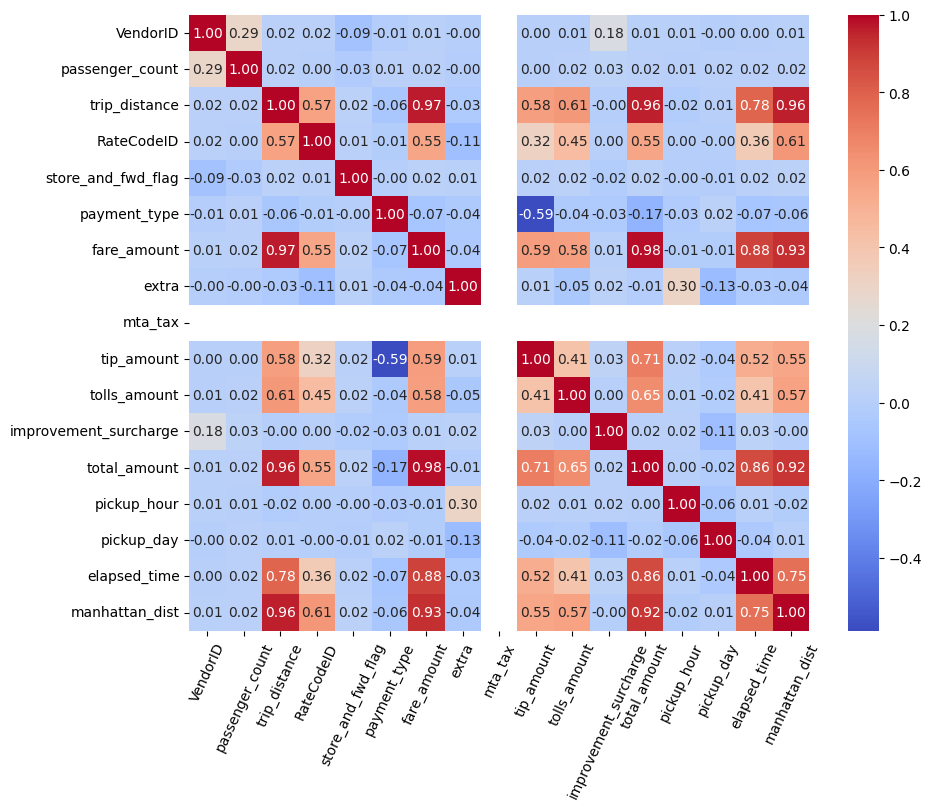

In [8]:
df_sample = df_clean.sample(frac=0.001)  # Adjust the fraction as needed
heatmap(df_sample.compute())

We can see that the trip distance is related to highly corelated to the total amount we paid, the tolls amount, the fare amount and so on. We also care for the RateCodeID since that influences the pricing. We can also see that the new features I added elapsed time and manhattan distance are also correlated. The first one less so than the second one but both can be useful. 

I will remove all lowly correlated features. I will also remove the total amount feature since it is a linear combination of the other amount features and so brings no new information but would make a model harder to train. The feature mta_tax is all white because it has a fixed value of 0.5 which doesn't change regardless of the trip so it can also be dropped. Before it was not like this but the cases where it was different thatn 0.5 were considered outliers and removed.

In [4]:
df_clean = df_clean.drop(['VendorID', 'passenger_count', 'store_and_fwd_flag', 'total_amount', 'extra', 'payment_type', 'mta_tax', 'improvement_surcharge'], axis=1)
df_clean = df_clean.persist()

### Think about standardizing your data before training your models. Describe the procedure:
To standardize the data I will remove the man of the columns and divide them by their standard deviation. Neverthelss since removed outliers in most classes we do not have numbers that are too high so overflows will not be an issue. Also I plan to use trees for interpreting feature importance which does not benefit from standardizing. As a result normalisation will not be a big benefit

In [53]:
df_clean.max(axis=0).round(2).compute()

trip_distance       20.600000
RateCodeID           6.000000
fare_amount         60.000000
tip_amount          14.580000
tolls_amount         5.540000
pickup_hour         23.000000
pickup_day           6.000000
elapsed_time      5071.000000
manhattan_dist    5122.949934
dtype: float64

In [54]:
df_clean.min(axis=0).compute()

trip_distance      0.02
RateCodeID         1.00
fare_amount        3.00
tip_amount         0.00
tolls_amount       0.00
pickup_hour        0.00
pickup_day         0.00
elapsed_time      45.00
manhattan_dist     0.00
dtype: float64

Below I do a train test split so I can evaluate metrics and give the example normalization

In [5]:
X, y = df_clean.drop('trip_distance', axis=1), df_clean['trip_distance']

# Select float64 to avoid categorical values
# I am normalizing the whole dataset since the goal of the task is to play around with dask
# This is not a good idea to do in practice. Should normalize only based on train set and save parameters for testing
numCols = X.select_dtypes(include=['float64'])
scaled_data = (numCols - numCols.mean(axis=0))/numCols.std(axis=0)

X[numCols.columns.to_list()] = scaled_data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = X_train.persist(), X_test.persist(), y_train.persist(), y_test.persist()

In [6]:
client = Client(n_workers=4, threads_per_worker=4, memory_limit='5GB')

## Evaluate the importance of the inputs in your model.
For this part of the task I decided to build an xg boosted trees and see how they estimates the importance of the features. I am not planning to fine tune the model since it takes a lot of time to train but it is usefull for the goals of the task

I will use the manhattan distance as a baseline the models I train

In [29]:
md = X['manhattan_dist'].compute().values
print("Baseline RMSE with manhattan distance: {:.2f}".format(root_mean_squared_error(y.compute().values, md)))

Baseline RMSE with manhattan distance: 5.33


In [7]:
model = xgb.dask.DaskXGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=1.0, colsample_bytree=0.8)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=5)

[01:35:56] task [xgboost.dask-0]:tcp://127.0.0.1:40495 got new rank 0
[01:35:56] task [xgboost.dask-1]:tcp://127.0.0.1:33947 got new rank 1
[01:35:56] task [xgboost.dask-2]:tcp://127.0.0.1:43109 got new rank 2
[01:35:56] task [xgboost.dask-3]:tcp://127.0.0.1:45377 got new rank 3


[0]	validation_0-rmse:2.81915
[1]	validation_0-rmse:2.54380
[2]	validation_0-rmse:2.29678
[3]	validation_0-rmse:2.07327
[4]	validation_0-rmse:1.87368
[5]	validation_0-rmse:1.70066
[6]	validation_0-rmse:1.54687
[7]	validation_0-rmse:1.40930
[8]	validation_0-rmse:1.28669
[9]	validation_0-rmse:1.17814
[10]	validation_0-rmse:1.07090
[11]	validation_0-rmse:0.97530
[12]	validation_0-rmse:0.89375
[13]	validation_0-rmse:0.81763
[14]	validation_0-rmse:0.74982
[15]	validation_0-rmse:0.68984
[16]	validation_0-rmse:0.63687
[17]	validation_0-rmse:0.59059
[18]	validation_0-rmse:0.55254
[19]	validation_0-rmse:0.51646
[20]	validation_0-rmse:0.48552
[21]	validation_0-rmse:0.45799
[22]	validation_0-rmse:0.43910
[23]	validation_0-rmse:0.42325
[24]	validation_0-rmse:0.40483
[25]	validation_0-rmse:0.39120
[26]	validation_0-rmse:0.37819
[27]	validation_0-rmse:0.36598
[28]	validation_0-rmse:0.35663
[29]	validation_0-rmse:0.34777
[30]	validation_0-rmse:0.34016
[31]	validation_0-rmse:0.33600
[32]	validation_0-

DaskXGBRegressor(colsample_bytree=0.8, eta=0.1, max_depth=7, n_estimators=1000,
                 subsample=1.0)

In [8]:
y_test_values = y_test.compute().values.copy()
predictions = model.predict(X_test).compute().copy()

rmse = root_mean_squared_error(y_test_values, predictions)
print("RMSE for xgboosted trees: {:.2f}".format(rmse))

RMSE for xgboosted trees: 0.27


We can see that the RMSE of the model is much better around 0.27 miles off from the true values which is less than 1/2 a kilometer which I would say is good for just training a random forest without fine-tuning it which is much better than the error or 5 miles of our baseline

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

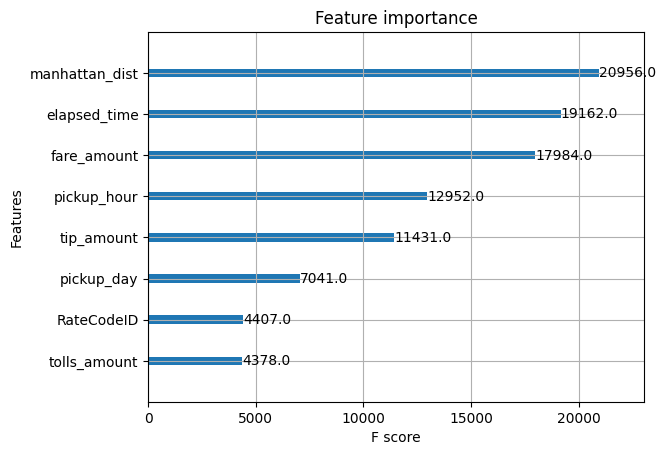

In [8]:
xgb.plot_importance(model, importance_type='weight')

In the feature importance graph above we can see how often a feature was chosen as a root for a split in the trees. We can see the parameters I added: manhattan distance and elapsed time are the most important and most often chosen which makes sense since one is a good approximation of the distance and assuming taxis move at a similar speed we can predict what distance they past. 

Information like pickup hour and pickup_day matter as well since they can be used to determine the amount of traffic. Maybe the model can predict rush hour times. 

Rate code ID on the other hand is not so important since most of its values are from one class. So it is likely chosen as a split less often since it will not divide the data well and does not give us a lot of information on the general case. To see value counts refer to the code section below

For fare_amount similar to elapsed time we can make an assumption on the distance knowing the rate code. I imagine the model learns similar information from the other paid amounts like tip and tolls. Possible conclusions are that for longer trips people give a bigger tip or the opposite since they already paid a lot. 

In [22]:
X_train['RateCodeID'].value_counts().compute()

RateCodeID
1    19969122
6          12
3          12
2      320256
5         737
4        3372
Name: count, dtype: int64

## Test (use machine learning evaluation techniques like cross-validation) your model and report the results.
I decided to swap out my model for LinearRegression with ridge loss called ridge regression because it trains faster compared to xgboosted trees and with the interest of time. For this task I compared the dask_ml implementation for LinearRegression with the expect it was more optimized compared to the scikit learn one but it was slower. It took 4s to train a Ridge regression of sklearn while with dask_ml it was around 5 minutes. I believe this is related to transfering data to the worker which takes time since the partitions are big. Since data fits into memory and scikitlearn can be used and it is much faster.

Also using GridSearchCV from dask_ml uses much more memory because it makes checkpoint to not repeat calculations. Those are saved in memory and I can run out of memory quickly on my local machine so it is better to run this against the cluster. To help with memory problems if I have a model with partial_fit I can use IncrementalSearchCV instead of GridSearchCV or HyperbandSearchCV which has also early stopping if I want to avoid unneeded computations.

In [ ]:
# different format needed for the grid search
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)
X_train = X_train.to_dask_array(lengths=True).persist()
y_train = y_train.to_dask_array(lengths=True).persist()

param_grid = {'alpha': np.arange(0.01, 0.4, 0.01)}

model = Ridge()
search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4)
#
search.fit(X_train, y_train)

In [25]:
print("Best estimator", search.best_estimator_)
print("Best score {:.2f}".format(search.best_score_))
y_t = y_test.to_dask_array(lengths=True).persist()
X_t = X_test.to_dask_array(lengths=True).persist()
print("RMSE on test set: {:.2f}".format(root_mean_squared_error(y_t, search.predict(X_t))))

Best estimator Ridge(alpha=0.39)
Best score 0.97
RMSE on test set: 0.57


We found the optimal alpha was 0.39 and that the model has an rmse of 0.57 meaning we are half a mile from the true value (around 0.9 km) which is worse than the xgboosted tree but still not bad for its simplicity depending on the precision we are after

In [16]:
client.close()